# <span style="color:#DC143C">NCF with Side Information (실험 3: Addition 방식 최적화) </span>
- #### 목표: 실험 1의 최적 조합에 대해 Addition 방식 세부 튜닝

* 조건: 실험 1에서 선정한 최적 조합 사용
  * 케이스7[Item+Category+Author+Publisher(Full)] 로 NDCG@10은 0.027004
* 실험방법
  * 전략 A : 단순 합(Sum)
    * enriched = item + Category + Author + Publisher
  * 전략 B : 평균(Average)
    * enriched = (item + Category + Author + Publisher) / 4.0
  * 전략 C : 가중 합(Weighted Sum) - 3가지 이상 시도
    * 조합1 : enriched = 1.0 * item + 2.0 * Category + 2.0 * Author + 2.0 * Publisher
    * 조합2 : enriched = 1.0 * item + 2.0 * Category + 1.0 * Author + 0.5 * Publisher
    * 조합3 : enriched = 1.0 * item + 2.0 * Category + 2.0 * Author + 3.0 * Publisher

* 구글 드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 0. 공통 설정 및 라이브러리 Imports

In [2]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score # 성능 평가
import sys
import warnings; warnings.filterwarnings("ignore")

In [3]:
def set_seed(seed=42):
    """
    실행 결과의 재현성(Reproducibility)을 보장하기 위해 난수 시드를 고정합니다.
    시드를 고정하면 코드를 다시 실행해도 동일한 결과를 얻을 수 있습니다.
    """
    # 1. Python 기본 random 모듈 시드 고정
    random.seed(seed)
    # 2. NumPy 시드 고정
    np.random.seed(seed)
    # 3. PyTorch CPU 연산 시드 고정
    torch.manual_seed(seed)
    # 4. CUDA (GPU) 사용 시 추가 시드 고정 및 설정
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # cuDNN 관련 설정으로, GPU 연산의 비결정성을 줄여줍니다.
        # 연산 속도가 다소 느려질 수 있지만, 재현성을 높여줍니다.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# 전역적으로 시드 고정 (재현성 확보)
SEED = 42
set_seed(SEED)

# 학습/추론에 사용할 디바이스 선택
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 디바이스: {device}")

사용 디바이스: cuda


In [4]:
# --- 임베딩 차원 설정 (Addition 방식은 모든 차원 통일 필요) ---
EMBED_DIM = 8  # GMF, MLP, Side Info 모두 동일 차원, 실험 1,2,3 (실험 4 제외)

# --- NCF 모델 구조 관련 ---
GMF_DIM = EMBED_DIM   # 8 GMF 경로 차원
MLP_DIM = EMBED_DIM   # 8
MLP_LAYERS = [64, 32, 16, 8] # 모든 실험 고정

# --- 학습 관련 ---
BATCH_SIZE = 128
EPOCHS = 20   # Early Stopping 사용
LR = 1e-4
DROPOUT_RATE = 0.3
PATIENCE = 3  # Early Stopping

# --- 추천 및 평가 관련 ---
TOP_K = 10
# TEST_USERS = 100

### 1. 데이터 준비

In [5]:
# 학습 데이터 로드 및 기본 정보 확인

# pickle 파일 구조: [train_df, test_df, train_item_meta, test_item_meta]
# - train_df, test_df: USER, ITEM, RATING 컬럼만 포함
# - train_item_meta, test_item_meta: ITEM, category_id, author_id, publisher_id 포함
train_df, test_df, train_item_meta, test_item_meta = pd.read_pickle('/content/drive/MyDrive/4학기/추천시스템/실습-20251011/개인과제/book_train_test_1v3.pkl')

# 전체 데이터 기준으로 M, N 계산 (첫 번째 NCF-pure와 동일한 방식)
all_data = pd.concat([train_df, test_df])
M = all_data['USER'].max() + 1   # Number of users
N = all_data['ITEM'].max() + 1   # Number of items

# Side info 개수도 전체 기준으로 계산: train과 test의 item_meta를 합쳐서 전체 unique 값의 개수를 구함
all_item_meta = pd.concat([train_item_meta, test_item_meta]).drop_duplicates('ITEM')
NUM_CATEGORIES = all_item_meta['category_id'].max() + 1
NUM_AUTHORS = all_item_meta['author_id'].max() + 1
NUM_PUBLISHERS = all_item_meta['publisher_id'].max() + 1

# Side info를 train_df에 병합 및 결측치 처리(혹시 매칭 안 되는 아이템이 있을 경우 0으로 채움)
train_df = train_df.merge(train_item_meta, on='ITEM', how='left')
train_df[['category_id', 'author_id', 'publisher_id']] = train_df[['category_id', 'author_id', 'publisher_id']].fillna(0).astype(int)

print(f"총 사용자 수 (M): {M}, 총 아이템 수 (N): {N}")
print(f"카테고리 수: {NUM_CATEGORIES}, 작가 수: {NUM_AUTHORS}, 출판사 수: {NUM_PUBLISHERS}")

총 사용자 수 (M): 9057, 총 아이템 수 (N): 26695
카테고리 수: 24, 작가 수: 16640, 출판사 수: 3043


In [6]:
train_df.head()

,USER,ITEM,RATING,category_id,author_id,publisher_id
0,242,16185,1.0,20,16576,2176
1,242,1586,0.0,7,9121,605
2,242,8682,0.0,8,7596,930
3,242,22087,0.0,15,15574,1854
4,2990,23683,1.0,2,7716,2537


In [7]:
# 데이터 준비: NCF Dataset 클래스 정의

class NCFDataset(Dataset):
    """
    NCF 학습을 위한 PyTorch Dataset 클래스
    Side information을 포함합니다
    """
    def __init__(self, df):
        self.users = torch.tensor(df['USER'].values, dtype=torch.long)
        self.items = torch.tensor(df['ITEM'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['RATING'].values, dtype=torch.float32)

        # Side info 추가
        self.categories = torch.tensor(df['category_id'].values, dtype=torch.long)
        self.authors = torch.tensor(df['author_id'].values, dtype=torch.long)
        self.publishers = torch.tensor(df['publisher_id'].values, dtype=torch.long)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return (self.users[idx], self.items[idx], self.categories[idx],
                self.authors[idx], self.publishers[idx], self.ratings[idx])

### 2. NCF 모델 정의

**NCF의 핵심 아이디어:**
- **GMF (Generalized Matrix Factorization)**: 전통적인 Matrix Factorization을 신경망으로 표현
  - 유저 벡터와 아이템 벡터를 **원소별 곱셈(element-wise product)**
  - 선형적인 상호작용 모델링 ("이 유저는 이 아이템과 얼마나 유사한가?")
  
- **MLP (Multi-Layer Perceptron)**: 비선형적 상호작용 학습
  - 유저 벡터와 아이템 벡터를 **연결(concatenation)**한 후 은닉층 통과
  - 복잡한 패턴 모델링 ("유저와 아이템의 잠재적 관계는?")
  
- **NeuMF**: GMF와 MLP의 출력을 결합하여 최종 예측
  - 두 모델의 장점을 모두 활용 (선형 + 비선형)

**왜 두 경로를 결합하는가?**
- GMF만 사용: 표현력 제한 (선형 관계만 포착)
- MLP만 사용: 단순 패턴 포착에 비효율적
- 결합: 단순한 패턴(GMF)과 복잡한 패턴(MLP)을 동시에 학습

In [8]:
class NCF(nn.Module):
    """
    Addition 방식으로 side info를 통합한 NCF 모델
    Item = Item_ID_embedding + Category_embedding + Author_embedding + Publisher_embedding
    """
    def __init__(self, num_users, num_items, num_categories, num_authors, num_publishers,
                 embed_dim, mlp_layers):
        super(NCF, self).__init__()

        # --- GMF 경로 (모든 embedding 차원 통일) ---
        self.mf_user_embed = nn.Embedding(num_users, embed_dim)
        self.mf_item_embed = nn.Embedding(num_items, embed_dim)
        self.mf_category_embed = nn.Embedding(num_categories, embed_dim)
        self.mf_author_embed = nn.Embedding(num_authors, embed_dim)
        self.mf_publisher_embed = nn.Embedding(num_publishers, embed_dim)

        # --- MLP 경로 (모든 embedding 차원 통일) ---
        self.mlp_user_embed = nn.Embedding(num_users, embed_dim)
        self.mlp_item_embed = nn.Embedding(num_items, embed_dim)
        self.mlp_category_embed = nn.Embedding(num_categories, embed_dim)
        self.mlp_author_embed = nn.Embedding(num_authors, embed_dim)
        self.mlp_publisher_embed = nn.Embedding(num_publishers, embed_dim)

        # --- MLP 레이어 (기존과 동일) ---
        mlp_modules = []
        input_size = embed_dim * 2  # user + enriched_item
        for layer_size in mlp_layers:
            mlp_modules.append(nn.Linear(input_size, layer_size))
            mlp_modules.append(nn.ReLU())
            mlp_modules.append(nn.Dropout(p=DROPOUT_RATE))
            input_size = layer_size
        self.mlp = nn.Sequential(*mlp_modules)

        # --- 최종 예측 레이어 ---
        final_input_size = embed_dim + mlp_layers[-1]
        self.predict_layer = nn.Linear(final_input_size, 1)

        self._init_weights()

    def _init_weights(self):
        """모든 임베딩 레이어 초기화"""
        # GMF embeddings
        nn.init.normal_(self.mf_user_embed.weight, std=0.01)
        nn.init.normal_(self.mf_item_embed.weight, std=0.01)
        nn.init.normal_(self.mf_category_embed.weight, std=0.01)
        nn.init.normal_(self.mf_author_embed.weight, std=0.01)
        nn.init.normal_(self.mf_publisher_embed.weight, std=0.01)

        # MLP embeddings
        nn.init.normal_(self.mlp_user_embed.weight, std=0.01)
        nn.init.normal_(self.mlp_item_embed.weight, std=0.01)
        nn.init.normal_(self.mlp_category_embed.weight, std=0.01)
        nn.init.normal_(self.mlp_author_embed.weight, std=0.01)
        nn.init.normal_(self.mlp_publisher_embed.weight, std=0.01)

        # Linear layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, user_indices, item_indices, category_indices, author_indices, publisher_indices, enriched_type):
        """
        Addition 방식
        """
        # --- GMF 경로 ---
        mf_user = self.mf_user_embed(user_indices)

        # Item + Side Info (Addition)
        if enriched_type == 'Strategy_B': # 평균(Average)
          mf_item_enriched = (
            (
            self.mf_item_embed(item_indices) +
            self.mf_category_embed(category_indices) +
            self.mf_author_embed(author_indices) +
            self.mf_publisher_embed(publisher_indices)
            ) / 4.0
          )
        elif enriched_type == 'Strategy_C_1': # 가중 합(Weighted Sum) - 조합1
           mf_item_enriched = (
              1.0 * self.mf_item_embed(item_indices) +
              2.0 * self.mf_category_embed(category_indices) +
              2.0 * self.mf_author_embed(author_indices) +
              2.0 * self.mf_publisher_embed(publisher_indices)
          )
        elif enriched_type == 'Strategy_C_2': # 가중 합(Weighted Sum) - 조합2
           mf_item_enriched = (
              1.0 * self.mf_item_embed(item_indices) +
              2.0 * self.mf_category_embed(category_indices) +
              1.0 * self.mf_author_embed(author_indices) +
              0.5 * self.mf_publisher_embed(publisher_indices)
          )
        elif enriched_type == 'Strategy_C_3': # 가중 합(Weighted Sum) - 조합3
           mf_item_enriched = (
              1.0 * self.mf_item_embed(item_indices) +
              2.0 * self.mf_category_embed(category_indices) +
              2.0 * self.mf_author_embed(author_indices) +
              3.0 * self.mf_publisher_embed(publisher_indices)
          )
        else: # Strategy_A # 단순 합(Sum)
          mf_item_enriched = (
            self.mf_item_embed(item_indices) +
            self.mf_category_embed(category_indices) +
            self.mf_author_embed(author_indices) +
            self.mf_publisher_embed(publisher_indices)
          )

        gmf_output = mf_user * mf_item_enriched

        # --- MLP 경로 ---
        mlp_user = self.mlp_user_embed(user_indices)

        # Item + Side Info (Addition)
        if enriched_type == 'Strategy_B': # 평균(Average)
          mlp_item_enriched = (
            (
            self.mlp_item_embed(item_indices) +
            self.mlp_category_embed(category_indices) +
            self.mlp_author_embed(author_indices) +
            self.mlp_publisher_embed(publisher_indices)
            ) /4.0
          )
        elif enriched_type == 'Strategy_C_1': # 가중 합(Weighted Sum) - 조합1
          mlp_item_enriched = (
            1.0 * self.mlp_item_embed(item_indices) +
            2.0 * self.mlp_category_embed(category_indices) +
            2.0 * self.mlp_author_embed(author_indices) +
            2.0 * self.mlp_publisher_embed(publisher_indices)
          )
        elif enriched_type == 'Strategy_C_2': # 가중 합(Weighted Sum) - 조합2
          mlp_item_enriched = (
            1.0 * self.mlp_item_embed(item_indices) +
            2.0 * self.mlp_category_embed(category_indices) +
            1.0 * self.mlp_author_embed(author_indices) +
            0.5 * self.mlp_publisher_embed(publisher_indices)
          )
        elif enriched_type == 'Strategy_C_3': # 가중 합(Weighted Sum) - 조합3
          mlp_item_enriched = (
              1.0 * self.mlp_item_embed(item_indices) +
              2.0 * self.mlp_category_embed(category_indices) +
              2.0 * self.mlp_author_embed(author_indices) +
              3.0 * self.mlp_publisher_embed(publisher_indices)
          )
        else: # Strategy_A # 단순 합(Sum)
          mlp_item_enriched = (
            self.mlp_item_embed(item_indices) +
            self.mlp_category_embed(category_indices) +
            self.mlp_author_embed(author_indices) +
            self.mlp_publisher_embed(publisher_indices)
        )
        mlp_input = torch.cat([mlp_user, mlp_item_enriched], dim=1)
        mlp_output = self.mlp(mlp_input)

        # --- NeuMF 결합 ---
        neumf_input = torch.cat([gmf_output, mlp_output], dim=1)
        logits = self.predict_layer(neumf_input).squeeze(-1)
        return logits

### 3. NCF 모델 학습

In [9]:
print("=== NCF 모델 학습 시작 ===")

def ncf_model_train(enriched_type) :
    # === NCF 모델 인스턴스 생성 ===
    model = NCF(
        num_users=M,
        num_items=N,
        num_categories=NUM_CATEGORIES,
        num_authors=NUM_AUTHORS,
        num_publishers=NUM_PUBLISHERS,
        embed_dim=EMBED_DIM,
        mlp_layers=MLP_LAYERS
    ).to(device)

    # === 손실 함수 및 옵티마이저 설정 ===
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-5)

    model.to(device) # 모델을 지정된 디바이스(CPU/GPU)로 이동
    model.train()
    loss_history = []
    best_val_loss = float('inf')
    trigger_times = 0

    # === 데이터 분할 및 재현성 확보 ===
    # 학습/검증(Train/Valid) 데이터 분할: 데이터를 랜덤하게 섞어서 분할합니다.
    # random_state=42를 사용하여 이 분할 과정도 재현성을 보장합니다.
    train_df_shuffled = train_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    split_idx = int(len(train_df_shuffled) * 0.9) # 90% 학습, 10% 검증
    train_data = train_df_shuffled.iloc[:split_idx]
    valid_data = train_df_shuffled.iloc[split_idx:]

    # DataLoader 생성: 배치 단위로 데이터를 모델에 공급
    # 학습 데이터는 매 Epoch마다 셔플(shuffle=True)하여 학습 다양성을 확보합니다.
    # 드롭아웃 등의 무작위성이 있지만, 전역 시드 설정으로 초기 조건이 고정되어 재현성이 보장됩니다.
    train_loader = DataLoader(NCFDataset(train_data), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    valid_loader = DataLoader(NCFDataset(valid_data), batch_size=BATCH_SIZE * 2, shuffle=False)

    for epoch in range(EPOCHS):
        # --- Training Loop ---
        total_train_loss = 0
        model.train() # 모델을 학습 모드로 설정 (Dropout 활성화)
        for user_batch, item_batch, cat_batch, author_batch, pub_batch, rating_batch in train_loader:
            # 데이터 디바이스 이동
            user_batch = user_batch.to(device)
            item_batch = item_batch.to(device)
            cat_batch = cat_batch.to(device)
            author_batch = author_batch.to(device)
            pub_batch = pub_batch.to(device)
            rating_batch = rating_batch.to(device)

            # Forward Pass
            logits = model(user_batch, item_batch, cat_batch, author_batch, pub_batch, enriched_type)
            loss = criterion(logits, rating_batch)

            # Backward Pass & Optimizer Step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # --- Validation Loop ---
        model.eval() # 모델을 평가 모드로 설정 (Dropout 비활성화)
        total_val_loss = 0
        with torch.no_grad():
            for user_val, item_val, cat_val, author_val, pub_val, rating_val in valid_loader:
                user_val = user_val.to(device)
                item_val = item_val.to(device)
                cat_val = cat_val.to(device)
                author_val = author_val.to(device)
                pub_val = pub_val.to(device)
                rating_val = rating_val.to(device)

                logits_val = model(user_val, item_val, cat_val, author_val, pub_val, enriched_type)
                loss_val = criterion(logits_val, rating_val)
                total_val_loss += loss_val.item()

        avg_val_loss = total_val_loss / len(valid_loader)

        loss_history.append({'loss': avg_train_loss, 'val_loss': avg_val_loss})

        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_val_loss:.4f}')

        # --- Early Stopping (조기 종료) ---
        # 검증 손실이 더 이상 개선되지 않으면 학습을 조기 종료하여 과적합을 방지합니다.
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= PATIENCE:
                print(f"Early stopping at epoch {epoch+1} (patience={PATIENCE})")
                break

    # 손실 곡선 시각화
    plt.figure(figsize=(8, 5))
    plt.plot([h['loss'] for h in loss_history], label="Train Loss")
    plt.plot([h['val_loss'] for h in loss_history], label="Validation Loss")
    plt.title("Training Loss History (BCE)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return model

=== NCF 모델 학습 시작 ===


### 4. NCF 성능 평가

In [10]:
def performance_predict(model, enriched_type):
    print(f"\n=== 추천 성능 평가 ===")

    # 모델을 평가 모드로 전환 (dropout, batch normalization 등이 비활성화됨)
    model.eval()

    # 평가용: 전체 아이템(0~N-1)의 side info 배열 생성
    # 예: N=10, all_item_meta에 ITEM [5, 7, 9]만 있는 경우
    #     ITEM  category_id  author_id  publisher_id
    #     5          10         100         1000
    #     7          20         200         2000
    #     9          30         300         3000
    meta_indexed = all_item_meta.set_index('ITEM')
    all_cats = meta_indexed['category_id'].reindex(range(N), fill_value=0).values
    # => [0, 0, 0, 0, 0, 10, 0, 20, 0, 30]
    all_authors = meta_indexed['author_id'].reindex(range(N), fill_value=0).values
    all_pubs = meta_indexed['publisher_id'].reindex(range(N), fill_value=0).values

    # 각 지표를 저장할 리스트 초기화
    recalls, precisions, ndcgs = [], [], []

    # 테스트 데이터의 모든 사용자에 대해 반복
    for user_id in test_df['USER'].unique():

        # === Ground Truth 준비 ===
        # 해당 사용자가 실제로 좋아한 아이템들 (RATING=1인 아이템들)을 집합으로 저장
        actual = set(test_df[test_df['USER']==user_id]['ITEM'].values)

        # 만약 사용자가 좋아하는 아이템이 하나도 없으면 평가 불가능하므로 건너뜀
        if len(actual) == 0:
            continue

        # === 모든 아이템에 대한 선호도 점수 예측 ===
        with torch.no_grad():  # 평가 시에는 gradient 계산 불필요 (메모리 절약, 속도 향상)
            # 사용자 ID를 N개(아이템 개수만큼) 복제한 텐서 생성
            # 예: user_id=5이면 [5, 5, 5, ..., 5] (N개)
            user_tensor = torch.full((N,), user_id, dtype=torch.long).to(device)

            # 모든 아이템 ID 생성 [0, 1, 2, ..., N-1]
            item_tensor = torch.arange(N, dtype=torch.long).to(device)


            # Side info 텐서 생성 (미리 만든 리스트 사용)
            cat_tensor = torch.tensor(all_cats, dtype=torch.long).to(device)
            author_tensor = torch.tensor(all_authors, dtype=torch.long).to(device)
            pub_tensor = torch.tensor(all_pubs, dtype=torch.long).to(device)

            # 모델을 통해 (사용자, 각 아이템) 쌍의 선호도 점수 계산
            logits = model(user_tensor, item_tensor, cat_tensor, author_tensor, pub_tensor, enriched_type)

            # Sigmoid 함수를 적용하여 0~1 사이의 확률값으로 변환 후 numpy 배열로 변환
            scores = torch.sigmoid(logits).cpu().numpy()

        # === Top-K 아이템 추출 ===
        # 점수가 높은 순서대로 정렬하여 상위 K개 아이템의 인덱스 추출
        # argsort: 오름차순 정렬된 인덱스 반환 → [-K:]: 뒤에서 K개 → [::-1]: 역순(내림차순)
        top_k_indices = np.argsort(scores)[-TOP_K:][::-1]

        # 추천된 상위 K개 아이템을 집합으로 변환 (교집합 연산을 위해)
        top_k_items = set(top_k_indices)

        # === NDCG (Normalized Discounted Cumulative Gain) 계산 ===
        # DCG 초기화 (순위를 고려한 누적 이득)
        dcg = 0.0

        # 추천된 각 아이템에 대해 순위별로 점수 계산
        for i, item in enumerate(top_k_indices):
            # 추천된 아이템이 실제로 좋아하는 아이템이면
            if item in actual:
                # 상위 순위일수록 높은 가중치 부여
                # log2(i+2)로 나누는 이유: i=0일 때 log2(2)=1, i=1일 때 log2(3)≈1.58...
                # 즉, 순위가 낮을수록 discount (할인) 적용
                dcg += 1.0 / np.log2(i + 2)

        # IDCG (Ideal DCG): 이상적인 경우의 DCG 값
        # 실제로 좋아하는 아이템을 모두 상위 순위에 추천했을 때의 최대 DCG
        # min(len(actual), K): 좋아하는 아이템이 K개보다 적을 수 있으므로
        idcg = sum([1.0 / np.log2(i + 2) for i in range(min(len(actual), TOP_K))])

        # NDCG: DCG를 IDCG로 정규화 (0~1 사이 값, 1에 가까울수록 좋음)
        # IDCG가 0이면 (좋아하는 아이템이 없으면) NDCG도 0
        ndcg = dcg / idcg if idcg > 0 else 0.0
        ndcgs.append(ndcg)

    # === 최종 결과 출력 ===
    # 모든 테스트 사용자에 대한 평균 지표 출력
    # 순위 고려 정확도
    ndcg10 = np.mean(ndcgs)
    return ndcg10

### 5. 베스트모델의 전략별 모델 훈련 및 성능비교

**************************************************
Strategy_A 테스트를 시작합니다.
Epoch [1/20], Train Loss: 0.5851, Valid Loss: 0.5340
Epoch [2/20], Train Loss: 0.5431, Valid Loss: 0.5194
Epoch [3/20], Train Loss: 0.5201, Valid Loss: 0.5100
Epoch [4/20], Train Loss: 0.5002, Valid Loss: 0.5040
Epoch [5/20], Train Loss: 0.4857, Valid Loss: 0.5024
Epoch [6/20], Train Loss: 0.4691, Valid Loss: 0.5003
Epoch [7/20], Train Loss: 0.4528, Valid Loss: 0.4978
Epoch [8/20], Train Loss: 0.4372, Valid Loss: 0.4929
Epoch [9/20], Train Loss: 0.4225, Valid Loss: 0.4897
Epoch [10/20], Train Loss: 0.4082, Valid Loss: 0.4856
Epoch [11/20], Train Loss: 0.3943, Valid Loss: 0.4874
Epoch [12/20], Train Loss: 0.3782, Valid Loss: 0.4898
Epoch [13/20], Train Loss: 0.3634, Valid Loss: 0.4937
Early stopping at epoch 13 (patience=3)


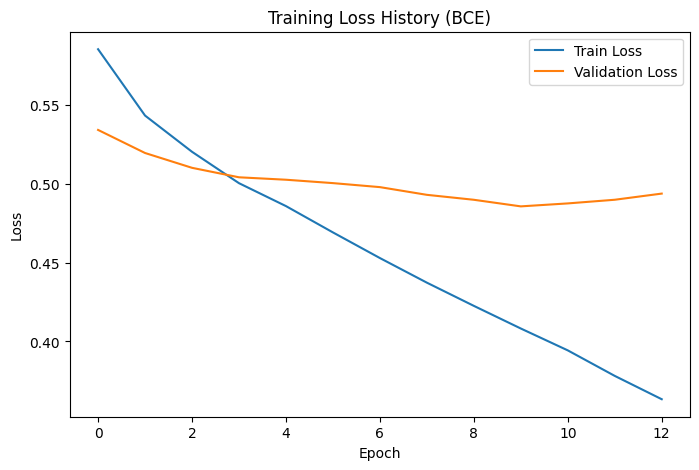


=== 추천 성능 평가 ===
Strategy_A 성능 = NDCG@10 : 0.0258
**************************************************
Strategy_B 테스트를 시작합니다.
Epoch [1/20], Train Loss: 0.5986, Valid Loss: 0.5444
Epoch [2/20], Train Loss: 0.5529, Valid Loss: 0.5292
Epoch [3/20], Train Loss: 0.5365, Valid Loss: 0.5250
Epoch [4/20], Train Loss: 0.5232, Valid Loss: 0.5299
Epoch [5/20], Train Loss: 0.5129, Valid Loss: 0.5354
Epoch [6/20], Train Loss: 0.5041, Valid Loss: 0.5403
Early stopping at epoch 6 (patience=3)


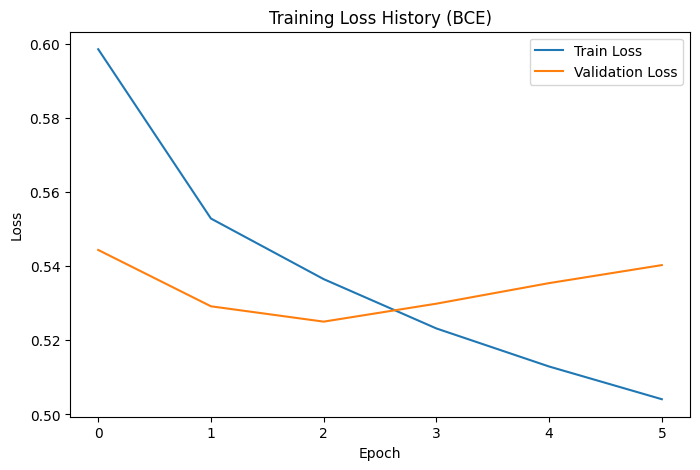


=== 추천 성능 평가 ===
Strategy_B 성능 = NDCG@10 : 0.0240
**************************************************
Strategy_C_1 테스트를 시작합니다.
Epoch [1/20], Train Loss: 0.5722, Valid Loss: 0.5299
Epoch [2/20], Train Loss: 0.5399, Valid Loss: 0.5240
Epoch [3/20], Train Loss: 0.5234, Valid Loss: 0.5226
Epoch [4/20], Train Loss: 0.5060, Valid Loss: 0.5184
Epoch [5/20], Train Loss: 0.4864, Valid Loss: 0.5137
Epoch [6/20], Train Loss: 0.4675, Valid Loss: 0.5072
Epoch [7/20], Train Loss: 0.4470, Valid Loss: 0.4967
Epoch [8/20], Train Loss: 0.4287, Valid Loss: 0.4915
Epoch [9/20], Train Loss: 0.4116, Valid Loss: 0.4844
Epoch [10/20], Train Loss: 0.3954, Valid Loss: 0.4819
Epoch [11/20], Train Loss: 0.3792, Valid Loss: 0.4825
Epoch [12/20], Train Loss: 0.3627, Valid Loss: 0.4864
Epoch [13/20], Train Loss: 0.3462, Valid Loss: 0.4900
Early stopping at epoch 13 (patience=3)


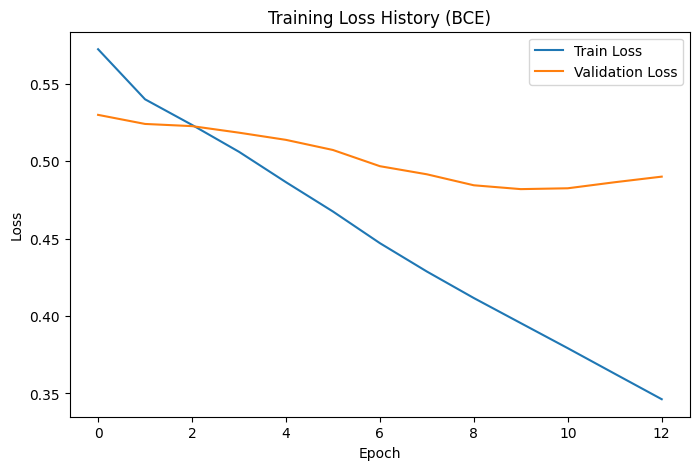


=== 추천 성능 평가 ===
Strategy_C_1 성능 = NDCG@10 : 0.0312
**************************************************
Strategy_C_2 테스트를 시작합니다.
Epoch [1/20], Train Loss: 0.5840, Valid Loss: 0.5330
Epoch [2/20], Train Loss: 0.5428, Valid Loss: 0.5201
Epoch [3/20], Train Loss: 0.5188, Valid Loss: 0.5111
Epoch [4/20], Train Loss: 0.4967, Valid Loss: 0.5038
Epoch [5/20], Train Loss: 0.4798, Valid Loss: 0.4995
Epoch [6/20], Train Loss: 0.4617, Valid Loss: 0.4939
Epoch [7/20], Train Loss: 0.4441, Valid Loss: 0.4908
Epoch [8/20], Train Loss: 0.4265, Valid Loss: 0.4842
Epoch [9/20], Train Loss: 0.4107, Valid Loss: 0.4780
Epoch [10/20], Train Loss: 0.3964, Valid Loss: 0.4787
Epoch [11/20], Train Loss: 0.3828, Valid Loss: 0.4792
Epoch [12/20], Train Loss: 0.3696, Valid Loss: 0.4816
Early stopping at epoch 12 (patience=3)


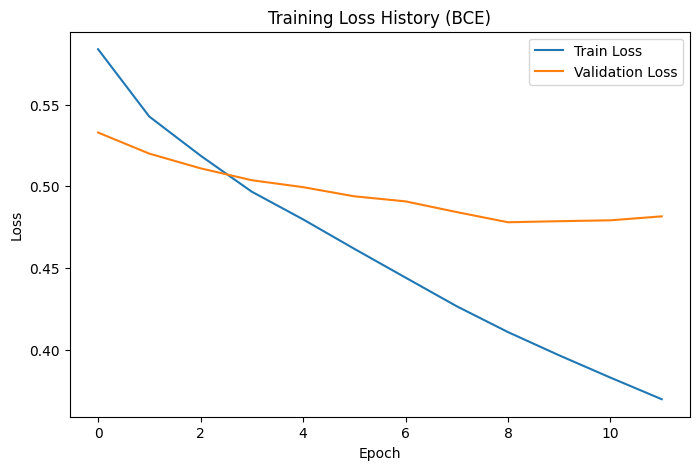


=== 추천 성능 평가 ===
Strategy_C_2 성능 = NDCG@10 : 0.0257
**************************************************
Strategy_C_3 테스트를 시작합니다.
Epoch [1/20], Train Loss: 0.5957, Valid Loss: 0.5385
Epoch [2/20], Train Loss: 0.5489, Valid Loss: 0.5233
Epoch [3/20], Train Loss: 0.5234, Valid Loss: 0.5058
Epoch [4/20], Train Loss: 0.5015, Valid Loss: 0.4933
Epoch [5/20], Train Loss: 0.4803, Valid Loss: 0.4840
Epoch [6/20], Train Loss: 0.4622, Valid Loss: 0.4755
Epoch [7/20], Train Loss: 0.4432, Valid Loss: 0.4683
Epoch [8/20], Train Loss: 0.4265, Valid Loss: 0.4631
Epoch [9/20], Train Loss: 0.4126, Valid Loss: 0.4601
Epoch [10/20], Train Loss: 0.3986, Valid Loss: 0.4569
Epoch [11/20], Train Loss: 0.3857, Valid Loss: 0.4569
Epoch [12/20], Train Loss: 0.3728, Valid Loss: 0.4573
Epoch [13/20], Train Loss: 0.3610, Valid Loss: 0.4602
Epoch [14/20], Train Loss: 0.3488, Valid Loss: 0.4651
Early stopping at epoch 14 (patience=3)


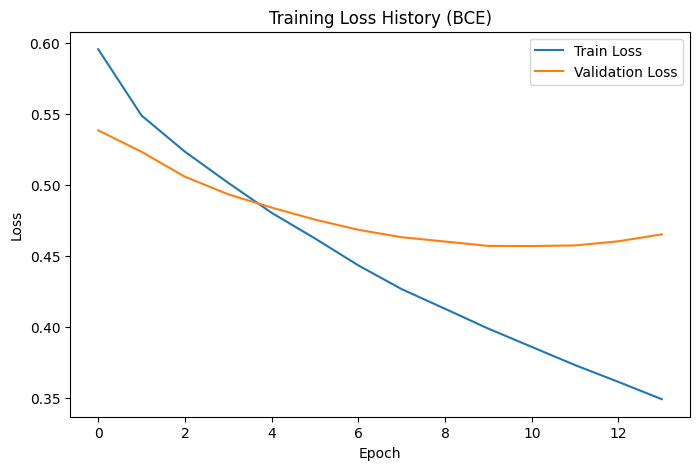


=== 추천 성능 평가 ===
Strategy_C_3 성능 = NDCG@10 : 0.0251


In [11]:
# 케이스별 설정 목록
strategy_case = ["Strategy_A", "Strategy_B", "Strategy_C_1", "Strategy_C_2", "Strategy_C_3"]

results = []  # 케이스별 성능 저장 리스트

# 케이스별 실행 루프
for strategy_name in strategy_case:
    print("*" * 50)
    print(f"{strategy_name} 테스트를 시작합니다.")

    # 모델 학습
    ncf_model = ncf_model_train(strategy_name)

    # 성능 평가
    ndcg10 = performance_predict(ncf_model, strategy_name)

    print(f"{strategy_name} 성능 = NDCG@{TOP_K} : {ndcg10:.4f}")

    # 결과 저장
    results.append({
        "STRATEGY": strategy_name,
        f"NDCG@{TOP_K}": ndcg10
    })

In [12]:
# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

# === NDCG 기준으로 내림차순 정렬 ===
results_df = results_df.sort_values(by=f"NDCG@{TOP_K}", ascending=False).reset_index(drop=True)

print("\n" + "=" * 60)
print("📊 전략별 성능 비교표 (내림차순 정렬)")
print("=" * 60)
print(results_df.to_string(index=False))


📊 전략별 성능 비교표 (내림차순 정렬)
    STRATEGY  NDCG@10
Strategy_C_1 0.031245
  Strategy_A 0.025795
Strategy_C_2 0.025685
Strategy_C_3 0.025070
  Strategy_B 0.023975


In [13]:
# 한글 폰트 설정 (Colab용)
!apt-get -qq -y install fonts-nanum

Selecting previously unselected package fonts-nanum.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [14]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 폰트 목록 갱신
fontpath = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(fontpath)
plt.rc('font', family='NanumGothic')  # 기본 폰트 변경
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

print("NanumGothic 폰트가 설정되었습니다.")

NanumGothic 폰트가 설정되었습니다.


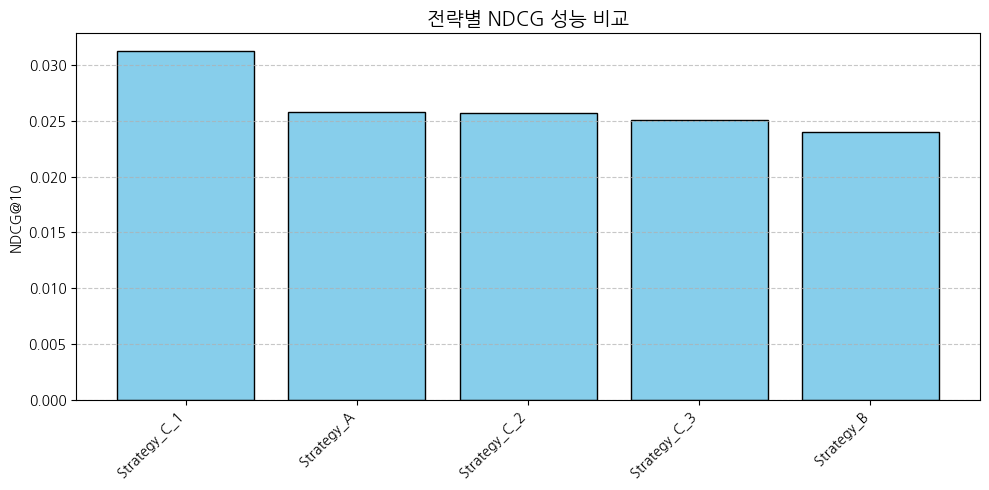

In [15]:
# === 막대그래프 시각화 ===
plt.figure(figsize=(10, 5))
plt.bar(results_df["STRATEGY"], results_df[f"NDCG@{TOP_K}"], color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.ylabel(f"NDCG@{TOP_K}")
plt.title("전략별 NDCG 성능 비교", fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 6. 실험3 결과 분석
* 최적 전략 및 가중치
  * 최적 전략은 C : 가중 합(Weighted Sum) 방식이다.
    * 조합1인  1.0 * item + 2.0 * Category + 2.0 * Author + 2.0 * Publisher 방식이 최적의 조합으로 결과가 산출되었다.

* 가중치가 성능에 미치는 영향

  (1) 단순 합 vs 평균
  * 단순 합은 모든 임베딩의 스케일과 중요도를 그대로 반영함
  * 평균은 각 임베딩의 기여도를 희석시켜 버림
    * Author, Publisher 같이 정보량이 많은 피처의 영향력이 줄어듦
    * 결과적으로 NDCG가 낮게 나타남

  (2) 가중합의 효과
  * 가중합은 각 피처의 정보 중요도·신뢰도에 맞게 조정 가능
  * Strategy_C_1의 효과적 조합
    * Category, Author, Publisher에 동일 가중치(2.0)를 주고, Item(1.0)보다 두 배로 강조.* 결과적으로 NDCG@10이 0.031245로 최고치 → Sum 대비 +21.1%, Average 대비 +30.3% 상승
      * 이는 메타데이터(Category/Author/Publisher)가 단순 Item latent보다 정보적 가치가 크며, 적절히 강조될 때 추천 품질을 극대화하는 효과가 나타남

* 도메인 지식과의 연관성
  * 최적 전략은 C 의 조합1은 1.0 * Item + 2.0 * Category + 2.0 * Author + 2.0 * Publisher
    * 이는 개별 아이템보다는 메타데이터 기반 맥락정보를 더 강하게 반영.
  * Category의 가중치 2.0
    * 사용자의 장르 취향은 지속적이고 예측력이 강함
  * Author의 가중치 2.0
    * 작가 기반 충성도 반영 (특정 저자 선호 → 일관된 추천 성공률 상승).
  * Publisher의 가중치 2.0
    * 출판사는 책의 품질·스타일 신호. 특정 출판사의 편집 방향을 신뢰하는 사용자 집단 존재.
  * Item의 가중치 1.0
    * 개별 아이템 정보는 사용자의 과거 선택을 그대로 반영하지만, 새로운 상황이나 다른 아이템으로 일반화하기는 어려움
    